In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import warnings
warnings.filterwarnings("ignore")
from random import randint
from scipy.signal import correlate
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

## reading the train and test data and merging them together in one dataset

In [3]:
df_train = pd.read_csv('train.csv',index_col='Id')
df_test = pd.read_csv('test.csv',index_col='Id')
# combine train and test datas in to one dataframe
df_all = pd.concat([df_train,df_test], sort=True)
df_all.head(2)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007


## Data tidying and Features Engineering

In [4]:
#look on other features values when TotalBsmtSF=0
cols_with_na = df_all.drop('SalePrice',axis=1).isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64


In [5]:
#look on other features values when TotalBsmtSF=0
df_all[df_all['TotalBsmtSF'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
2121,896,0,0,NaN,2,1Fam,NaN,NaN,NaN,NaN,...,ConLD,0,Pave,4,NaN,AllPub,0,1946,1950,2008


In [6]:
#filling the NaN values
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    df_all[col].fillna(0, inplace=True)
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish",  "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    df_all[col].fillna("missing", inplace=True)
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)

In [7]:
df_all['MSSubClass'] = df_all['MSSubClass'].apply(float)
df_all['YrSold'] = df_all['YrSold'].astype(float)
df_all['MoSold'] = df_all['MoSold'].astype(float)

In [8]:
# creating 'BsmtFullBath' new feature which is 'half' + 'full' bathrooms and drop these two features
df_all['BsmtFullBath'] = df_all['BsmtFullBath'] + 0.5*df_all['BsmtHalfBath']
df_all['FullBath'] = df_all['FullBath'] + 0.5*df_all['HalfBath']
df_all.drop(['BsmtHalfBath','HalfBath'],axis=1,inplace=True)

In [9]:
#creatinf 'HasPool' and 'Has3SsnPorch' features, which we check where PoolArea and 3SsnPorch 
#more than 0 then house has a pool and a SsnPorch  and drop these two columns and PoolQC also
df_all['HasPool'] = (df_all['PoolArea']>0)
df_all['Has3SsnPorch'] = (df_all['3SsnPorch']>0)
df_all.drop(['PoolQC','PoolArea','3SsnPorch'],axis=1,inplace=True)

check the relation between Fence, Alley, and MiscFeature columns with the Sale Price column, where these three columns have a lot of nan values, to see if we can drop it or no

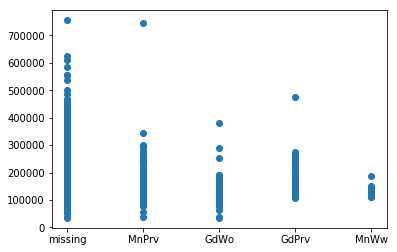

In [10]:
plt.scatter(df_all['Fence'],df_all['SalePrice'])

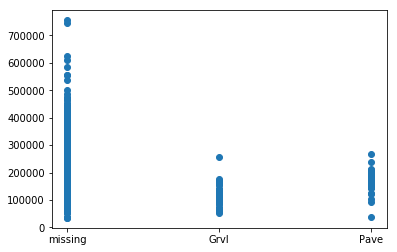

In [11]:
plt.scatter(df_all['Alley'],df_all['SalePrice'])

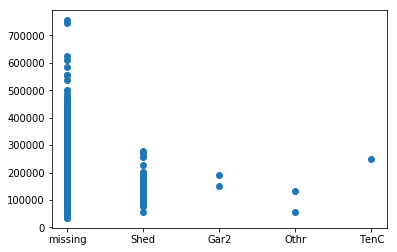

In [12]:
plt.scatter(df_all['MiscFeature'],df_all['SalePrice'])

In [13]:
# We can notice that from the scatter plot there is not a strong relation between these columns and Sale Price

In [14]:
cols_high_na=['MiscFeature','Alley','Fence']
df_all.drop(cols_high_na,axis=1,inplace=True)

In [15]:
#counting zeros values in our dataset
zeros_cols = ((df_all==0).sum()/len(df_all))
zeros_cols = zeros_cols[zeros_cols>0]
print(zeros_cols.sort_values(ascending=False))

HasPool          0.995546
Has3SsnPorch     0.987324
LowQualFinSF     0.986297
MiscVal          0.964714
ScreenPorch      0.912299
BsmtFinSF2       0.881124
EnclosedPorch    0.842754
MasVnrArea       0.603289
2ndFlrSF         0.571429
BsmtFullBath     0.531689
WoodDeckSF       0.521754
Fireplaces       0.486468
OpenPorchSF      0.444673
BsmtFinSF1       0.318602
BsmtUnfSF        0.082905
GarageArea       0.054128
GarageCars       0.054128
TotalBsmtSF      0.027064
BedroomAbvGr     0.002741
KitchenAbvGr     0.001028
FullBath         0.001028
dtype: float64


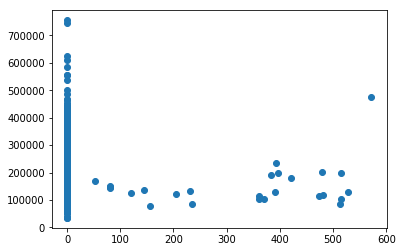

In [16]:
# see the relation between HasPool,Has3SsnPorch and LowQualFinSF with Sale Price
plt.scatter(df_all['LowQualFinSF'],df_all['SalePrice'])

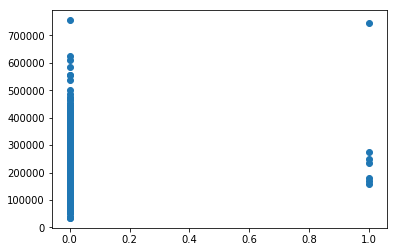

In [17]:
plt.scatter(df_all['HasPool'],df_all['SalePrice'])

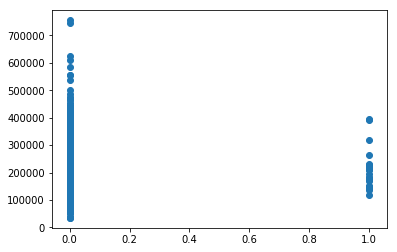

In [18]:
plt.scatter(df_all['Has3SsnPorch'],df_all['SalePrice'])

In [19]:
frac_zeros = ((df_all==0).sum()/len(df_all))
# no. unique values in each column
n_unique = df_all.nunique()

# difference between frac. zeros and expected
# frac. zeros if values evenly distributed between
# classes
xs_zeros = frac_zeros - 1/n_unique

# create dataframe and display which columns may be problematic
zero_cols = pd.DataFrame({'frac_zeros':frac_zeros,'n_unique':n_unique,'xs_zeros':xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='xs_zeros',ascending=False,inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])

,frac_zeros,n_unique,xs_zeros
LowQualFinSF,0.986297,36,0.958519
MiscVal,0.964714,38,0.938398
ScreenPorch,0.912299,121,0.904034
BsmtFinSF2,0.881124,272,0.877447
EnclosedPorch,0.842754,183,0.837290
MasVnrArea,0.603289,444,0.601037
2ndFlrSF,0.571429,635,0.569854
WoodDeckSF,0.521754,379,0.519116
HasPool,0.995546,2,0.495546
Has3SsnPorch,0.987324,2,0.487324


In [20]:
# add new feature for each column has a high number of zeros, where the new features is 0 or 1 that depend on if the feature > 0 or no
dummy_cols = zero_cols[(zero_cols.xs_zeros>0)].index
for col in dummy_cols:
    df_all['Has'+col] = (df_all[col]>0).astype(int)

In [21]:
#get numeric columns

In [22]:
df_all_num=[]
for col in df_all.columns:
    if df_all[col].dtype.name!='object':
        df_all_num.append(col)

In [23]:
#get categoris columns
df_all_cat=[]
for col in df_all.columns:
    if df_all[col].dtype.name=='object':
        df_all_cat.append(col)

In [24]:
#view categories data
df_all[df_all_cat].head(2)

,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
Id,,,,,,,,,,,,,,,,,,,,,
1,1Fam,TA,No,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
2,1Fam,TA,Gd,ALQ,Unf,Gd,Y,Feedr,Norm,SBrkr,...,RL,None,Veenker,Y,CompShg,Gable,Normal,WD,Pave,AllPub


In [25]:
cols_with_na = df_all.drop('SalePrice',axis=1).isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

LotFrontage    486
GarageYrBlt    159
dtype: int64


In [26]:
#fill NaN values in 'GarageYrBlt' column with replacing NaN values with the year that house was built in
df_all.loc[df_all.GarageYrBlt.isnull(),'GarageYrBlt'] = df_all.loc[df_all.GarageYrBlt.isnull(),'YearBuilt']

In [27]:
#fill LotFrontage NaN values by predicting these values using Ridge model
df=pd.get_dummies(df_all)
test_LotFrontage=df.loc[df.LotFrontage.isna()]
train_LotFrontage=df.loc[df.LotFrontage.notna()]
X_train,y_train=train_LotFrontage.drop(['LotFrontage','SalePrice'],axis=1),train_LotFrontage['LotFrontage']
X_test,y_test=test_LotFrontage.drop(['LotFrontage','SalePrice'],axis=1),test_LotFrontage['LotFrontage']
lr=linear_model.Ridge().fit(X_train,y_train)
y_=lr.predict(X_test)
y_test=pd.Series(y_)

j=0
for i in test_LotFrontage.index:
    df_all.set_value(i,'LotFrontage',y_[j])
    j+=1

In [28]:
#removing outliers and correcting some of them instead of removing

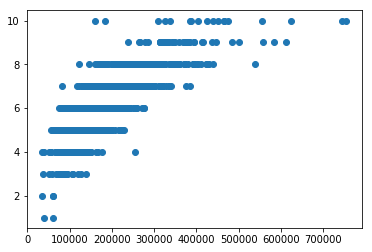

In [29]:
plt.scatter(df_all['SalePrice'],df_all['OverallQual'])

In [30]:
df_all.drop(df_all[(df_all['OverallQual']<5) & (df_all['SalePrice']>200000)].index, inplace=True)

In [31]:
#df_all.drop(df_all[(df_all['OverallQual']>9) & (df_all['SalePrice']<200000)].index, inplace=True)

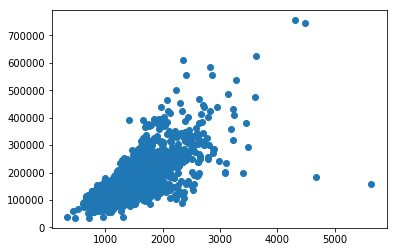

In [32]:
plt.scatter(df_all['GrLivArea'],df_all['SalePrice'])

In [33]:
df_all.drop(df_all[(df_all["GrLivArea"]>4000)&(df_all["SalePrice"]<300000)].index,inplace=True)

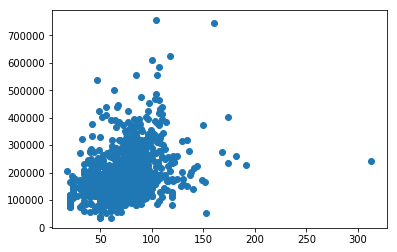

In [34]:
plt.scatter(df_all['LotFrontage'],df_all['SalePrice'])

In [35]:
for index,row in df_all.iterrows():
    if (row['LotFrontage']>300) & (row['SalePrice']<300000):
        df_all.set_value(index, 'LotFrontage', df_all['LotFrontage'].mode()[0])
    elif (row['LotFrontage']>150) & (row['SalePrice']<100000):
        df_all.set_value(index, 'LotFrontage', 80)

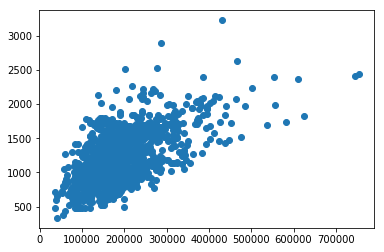

In [36]:
plt.scatter(df_all['SalePrice'],df_all['1stFlrSF'])

In [37]:
#df_all.drop(df_all[(df_all["SalePrice"]>700000)].index,inplace=True)

In [38]:
#creating a new feature 'TotArea'
df_all['TotArea']=df_all['1stFlrSF']+df_all['2ndFlrSF']+df_all['TotalBsmtSF']
df_all=df_all.drop(['1stFlrSF','2ndFlrSF','TotalBsmtSF'],axis=1)

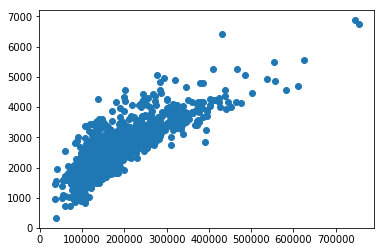

In [39]:
plt.scatter(df_all['SalePrice'],df_all['TotArea'])

In [40]:
#plt.scatter(df_all['SalePrice'],df_all['2ndFlrSF'])

In [41]:
#creating new features TotalPlace, PorchQual,TotArea,ToT,BsmtFinSF1Qual,Bsmt,Romms,LotArea
df_all["TotalPlace"] =( df_all["TotArea"] + df_all["GarageArea"] + df_all["OpenPorchSF"])* df_all["OverallQual"]
df_all["PorchQual"] = df_all["OpenPorchSF"] * df_all["OverallQual"]
df_all["TotArea"] = df_all["TotArea"] * df_all["OverallQual"]
df_all['ToT']=(df_all['TotArea']+df_all['GrLivArea']+df_all["BsmtFinSF2"] +df_all['GarageArea']+df_all['BsmtFinSF1'])*df_all['OverallQual']
df_all['BsmtFinSF1Qual']=df_all['BsmtFinSF1']*df_all['OverallQual']
#df_all=df_all.drop(['TotArea','GrLivArea','GarageArea','OverallQual'],axis=1)
df_all["Bsmt"] =( df_all["BsmtFinSF1"] + df_all["BsmtUnfSF"])* df_all["OverallQual"]
df_all["Rooms"] = (df_all["FullBath"]+df_all["TotRmsAbvGrd"])* df_all["OverallQual"]
df_all["LotArea"] = df_all["LotArea"] * df_all["OverallQual"]

In [42]:
#droping 'BsmtFinSF2' column
df_all.drop(['BsmtFinSF2'],axis=1,inplace=True)

In [43]:
#df_all=df_all.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'],axis=1)

In [44]:
#plt.scatter(df_all['ToT'],df_all['SalePrice'])

In [45]:
(df_all["ToT"] ).corr(df_all['SalePrice'])

0.9256692433689366

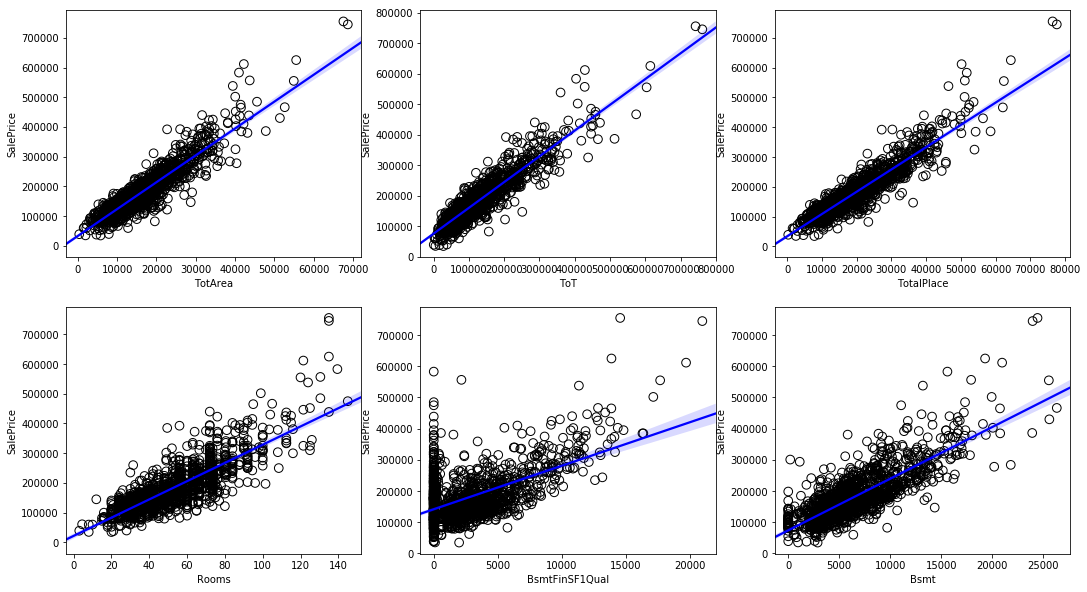

In [46]:
#scatter the realtionship between new features and Sale Price
import seaborn as sns
plt.figure(figsize=(18,10))
features=['TotArea','ToT','TotalPlace','Rooms','BsmtFinSF1Qual','Bsmt']
for i in range(len(features)):
    ii = '23'+str(i+1)
    plt.subplot(ii)
    plt.scatter(df_all[features[i]], df_all['SalePrice'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = features[i], y = 'SalePrice', data = df_all,scatter=False, color = 'Blue')

In [47]:
df_all_num=[]
for col in df_all.columns:
    if df_all[col].dtype.name!='object':
        df_all_num.append(col)

### Normalazing numeric data

In [48]:
loglist = ['SalePrice','LotFrontage','LotArea','BsmtFinSF1','BsmtUnfSF',
                 'TotalPlace','TotArea','ToT','GrLivArea',
                 'BsmtFullBath','FullBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'YearRemodAdd','BsmtFinSF1Qual','Bsmt','Rooms']
df_all_num=df_all_num
num_no_scale=[item for item in df_all_num if item not in loglist]
#df_numeric=df_all[num_no_scale]
df_numeric=pd.concat([np.log1p(df_all[loglist]),df_all[num_no_scale]],axis=1)
#df_numeric=df_numeric.drop
#df_numeric['SalePrice']=np.log(df_numeric['SalePrice'])
#len(df_numeric[df_numeric==0])
df_numeric.head(2)

,SalePrice,LotFrontage,LotArea,BsmtFinSF1,BsmtUnfSF,TotalPlace,TotArea,ToT,GrLivArea,BsmtFullBath,...,HasHasPool,HasHas3SsnPorch,HasOpenPorchSF,HasBsmtFullBath,HasBsmtFinSF1,HasFireplaces,HasBsmtUnfSF,HasGarageArea,HasTotalBsmtSF,PorchQual
Id,,,,,,,,,,,,,,,,,,,,,
1,12.247699,4.189655,10.987849,6.561031,5.017280,10.009018,9.796069,11.894665,7.444833,0.693147,...,0,0,1,1,1,0,1,1,1,427
2,12.109016,4.394449,10.961295,6.886532,5.652489,9.792835,9.625426,11.581191,7.141245,0.405465,...,0,0,0,1,1,1,1,1,1,0


In [49]:
#converting categories data to numeric data

In [50]:
df_cat=df_all[df_all_cat]

In [51]:
df_cat=pd.get_dummies(df_cat)

In [52]:
df_cat.head(2)

,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_missing,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
Id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0


In [53]:
corr=[]
for column in df_cat.columns:
    corr.append([column,abs(df_numeric['SalePrice'].corr(df_cat[column]))])
corr=pd.DataFrame(corr)
corr.columns=['ColumnName','SalePrice']
corr=corr.sort_values(['SalePrice'], ascending=[0])

In [54]:
corr.head(5)

,ColumnName,SalePrice
66,ExterQual_TA,0.597368
162,KitchenQual_TA,0.538177
106,Foundation_PConc,0.532205
65,ExterQual_Gd,0.510752
103,FireplaceQu_missing,0.509913


In [55]:
#creating our final data which is a merge between categoris and numeric data

In [56]:
df_model=pd.concat([df_numeric,df_cat],axis=1)

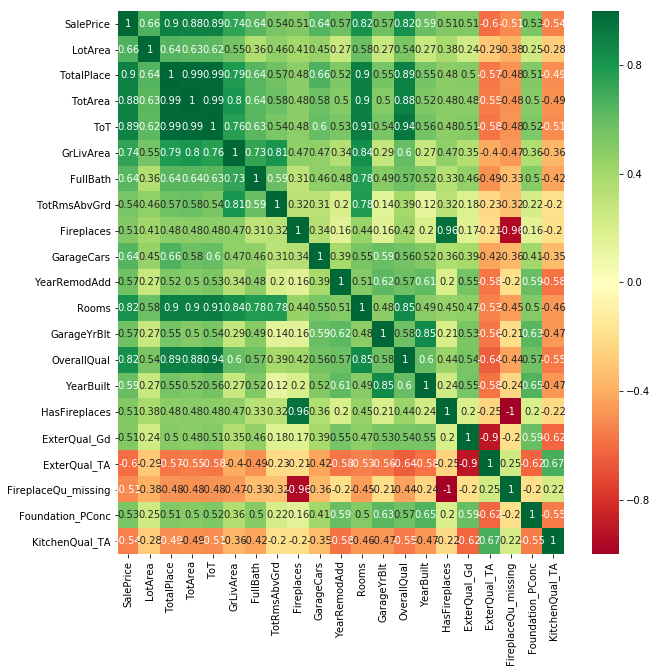

In [58]:
# most correlated features with SalePrice
plt.figure(figsize=(10,10))
corrmat = df_model.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
sns.heatmap(df_model[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### We can notice that there are many features that highly correlated to each other, so we tried to remove one variavle from each pairwise correlated variables, but that didn't improve our score.

In [140]:
frac_zeros = ((df_model==0).sum()/len(df_model))
# no. unique values in each column
n_unique = df_model.nunique()

# difference between frac. zeros and expected
# frac. zeros if values evenly distributed between
# classes
xs_zeros = frac_zeros - 1/n_unique

# create dataframe and display which columns may be problematic
zero_cols = pd.DataFrame({'frac_zeros':frac_zeros,'n_unique':n_unique,'xs_zeros':xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='frac_zeros',ascending=False,inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])

,frac_zeros,n_unique,xs_zeros
Utilities_NoSeWa,0.999657,2,0.499657
Heating_Floor,0.999657,2,0.499657
RoofMatl_Metal,0.999657,2,0.499657
RoofMatl_Membran,0.999657,2,0.499657
Condition2_RRAe,0.999657,2,0.499657
Condition2_RRAn,0.999657,2,0.499657
Electrical_Mix,0.999657,2,0.499657
Exterior1st_ImStucc,0.999657,2,0.499657
Exterior2nd_Other,0.999657,2,0.499657
RoofMatl_Roll,0.999657,2,0.499657


In [141]:
zero_cols[100:101]

,frac_zeros,n_unique,xs_zeros
SaleCondition_Family,0.984225,2,0.484225


In [142]:
#Lasso model selection and building differnt datasets from our dataset but each
#dataset with different numbers of featires
lasso=linear_model.Lasso(alpha=0.001)
X,y=df_model[0:1457].drop(['SalePrice'],axis=1).values,(df_model['SalePrice'][0:1457]).values
lasso.fit(X,y)
FI_lasso = pd.DataFrame({"Feature Importance":abs(lasso.coef_)}, index=df_model.drop(['SalePrice'],axis=1).columns)
FI_lasso=FI_lasso.sort_values("Feature Importance",ascending=False)

In [143]:
df_model2=df_model.drop(list(FI_lasso.index)[73:],axis=1)

In [144]:
df_model3=df_model.drop(list(FI_lasso.index)[150:],axis=1)

In [145]:
df_model4=df_model.drop(list(FI_lasso.index)[60:],axis=1)

In [146]:
df_model5=df_model.drop(list(zero_cols.index)[0:100],axis=1)
df_model6=df_model[(df_model2.columns).intersection(df_model5.columns)]

### Traing data and Modelization 

In [147]:
#models
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
'''this function is to predict Sale Price of test set data
input: dataset,model
output: sale price prediction values, RMSE, and prediction values of Sale Price of train dataset'''
def predict_data(df_model,mod):
    df_model=df_model.reset_index()
    X,y=df_model[0:1457].drop(['SalePrice'],axis=1).values,(df_model['SalePrice'][0:1457]).values
    X_test,y_test =df_model[1457:].drop(['SalePrice'],axis=1).values,(df_model['SalePrice'][1457:]).values
    # create cross-validation method
    kf = KFold(n_splits=20)  
    kf.get_n_splits(X)
    min_e=np.Inf
    pred=0
    train_pred=0
    rmse_score=0
    random_state = 1234
    #split on 30 flods and repeat for six times
    rkf = RepeatedKFold(n_splits=30, n_repeats=6, random_state=random_state)
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model=mod.fit(X_train, y_train)
        y_pred=mod.predict(X_test)
        #each time we compare our new prediction rmsle error vs the minimum rmsle value that we
        #have got in previous iterations, and if we got a new minimum value then we update our 
        #predictions, and rmsle value
        if np.sqrt(np.mean((np.log(1+np.exp(y_pred)) - np.log(1+np.exp(y_test)))**2))<min_e:
            min_e=np.sqrt(np.mean((np.log(1+np.exp(y_pred)) - np.log(1+np.exp(y_test)))**2))
            rmse_score=np.sqrt(np.mean((np.log(1+np.exp(y_pred)) - np.log(1+np.exp(y_test)))**2))
            X_test=df_model[1457:].drop(['SalePrice'],axis=1).values
            pred=model.predict(X_test)
            pred = np.exp(pred)
            train_pred=model.predict(X)
            train_pred = pd.concat([pd.DataFrame(np.exp(train_pred)),pd.DataFrame(np.exp(y))],axis=1)
            train_pred.columns = ['Predictions','SalePrice']
            #pred=[int(item) for item in pred]
            pred = pd.DataFrame(pred,index=range(1461,2920))
            pred.columns = ['SalePrice']
        
    return pred,rmse_score,train_pred

In [148]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

### GradientBoostingRegressor

In [155]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 3) 
gbr,rmg,modg=predict_data(df_model,myGBR)

In [156]:
rmg

0.06104811805717978

In [157]:
gbr.head(5)

,SalePrice
1461,125954.635801
1462,156120.001299
1463,189525.683050
1464,195417.044059
1465,187111.177127


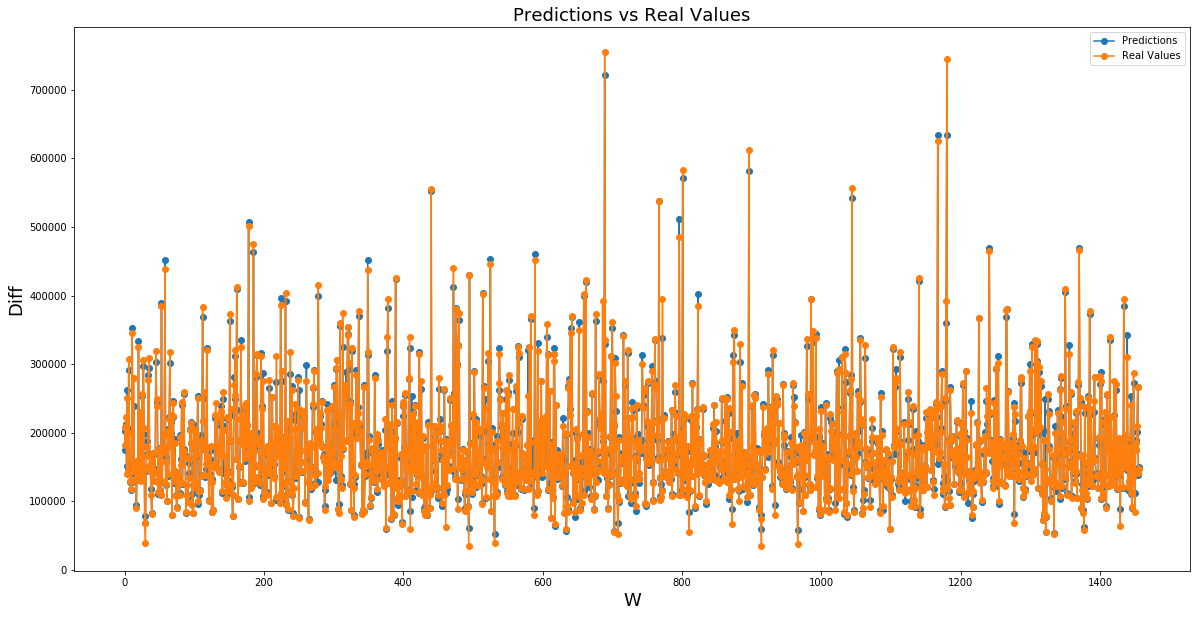

In [220]:
plt.figure(figsize=(20,10))
plt.plot([( row['Predictions'],row['SalePrice']
              ) for index, row in modg.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['Predictions','Real Values'], fontsize=10, loc='upperleft')
plt.show()

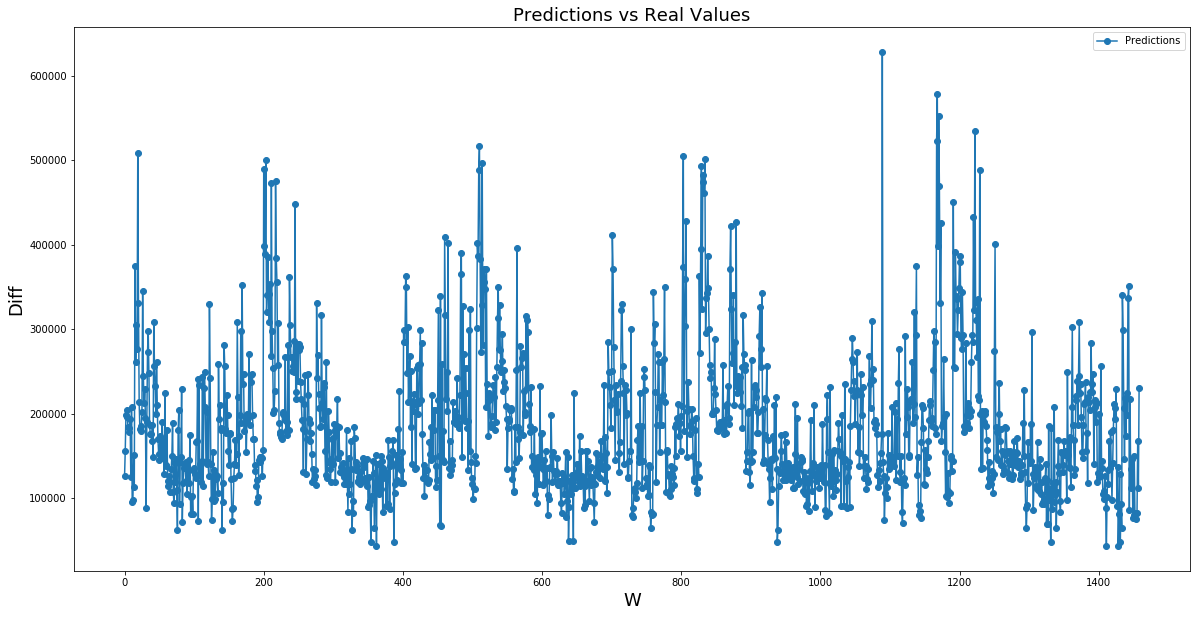

In [221]:
plt.figure(figsize=(20,10))
plt.plot([( row['SalePrice']
              ) for index, row in gbr.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['Predictions'], fontsize=10, loc='upperleft')
plt.show()

In [225]:
max(gbr.SalePrice)

628656.1690700215

In [226]:
min(gbr.SalePrice)

43118.61153875894

In [ ]:
### we notice that gbr give high prediction values, depending on the average of our previous
### submissions we notice that the range of data is approximitly between 30.000 and 550000,
###so we will try to improve gbr prediction values manulay
gbr[gbr.SalePrice<60000]=gbr[gbr.SalePrice<60000]-10000
gbr[gbr.SalePrice>157000]=gbr[gbr.SalePrice>157000]+9000

In [ ]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 3) 
gbr2,rmg,modg2=predict_data(df_model2,myGBR)

In [ ]:
rmg

In [ ]:
gbr2.head(5)

In [158]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 3) 
gbr3,rmg,modg3=predict_data(df_model3,myGBR)

In [159]:
gbr3.head(5)

,SalePrice
1461,129899.983121
1462,158252.312842
1463,187686.839357
1464,200075.244411
1465,187176.597284


In [160]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 3) 
gbr4,rmg,modg4=predict_data(df_model4,myGBR)

In [161]:
gbr4.head(5)

,SalePrice
1461,130521.044206
1462,159456.290714
1463,186962.200137
1464,201852.932602
1465,182486.794318


In [162]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 5) 
gbr5,rmg,modg5=predict_data(df_model5,myGBR)

In [163]:
rmg

0.06094100532015264

In [164]:
gbr5.head(5)

,SalePrice
1461,125792.186140
1462,157164.260202
1463,186946.920001
1464,194868.363349
1465,185698.012299


In [165]:
myGBR = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.02,
                                      max_depth=4, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=50,
                                      loss='huber', random_state = 5) 
gbr6,rmg,modg5=predict_data(df_model6,myGBR)

In [166]:
rmg

0.06190212595334206

In [167]:
gbr6.head(5)

,SalePrice
1461,129648.404508
1462,155632.367401
1463,187748.983155
1464,199798.385422
1465,188996.221233


### Lasso

In [168]:
lasso1 = make_pipeline(RobustScaler(), linear_model.Lasso(alpha =0.0008))
p,rm,mod=predict_data(df_model,lasso1)

In [169]:
rm

0.06821189583207497

In [170]:
p.head(5)

,SalePrice
1461,116360.693449
1462,147798.410493
1463,179439.761744
1464,194784.505290
1465,193495.611800


In [ ]:
lasso1 = make_pipeline(RobustScaler(), linear_model.Lasso(alpha =0.0008))
p2,rm,mod2=predict_data(df_model2,lasso1)

In [ ]:
rm

In [ ]:
p2.head(5)

### Linear Regression

In [171]:
lin = make_pipeline(RobustScaler(), linear_model.LinearRegression())

In [172]:
pLL,rmL,modL=predict_data(df_model,lin)

In [173]:
rmL

0.06843045846009208

In [ ]:
pLL.head(5)

In [ ]:
pLL2,rmL,modL=predict_data(df_model2,lin)

In [ ]:
rmL

In [ ]:
pLL2.head(7)

### Ridge

In [174]:
L,rmL,mL=predict_data(df_model,linear_model.Ridge(alpha=0.0008))

In [175]:
rmL

0.06835456465407935

In [176]:
L.head(5)

,SalePrice
1461,117941.500180
1462,157019.466151
1463,186974.758019
1464,197717.326184
1465,196620.745703


In [ ]:
L2,rmL,mL2=predict_data(df_model2,linear_model.Ridge(alpha=0.0008))

In [ ]:
rmL

In [ ]:
L2.head(5)

### ElasticNet

In [177]:
ENet = make_pipeline(RobustScaler(), linear_model.ElasticNet(alpha=0.0009, l1_ratio=0.005))
pE,rmE,m=predict_data(df_model,ENet)

In [178]:
rmE

0.06467766694015627

In [179]:
pE.head(5)

,SalePrice
1461,116013.511720
1462,154418.913579
1463,184817.975667
1464,195218.494416
1465,196975.718229


In [ ]:
ENet = make_pipeline(RobustScaler(), linear_model.ElasticNet(alpha=0.0009, l1_ratio=0.005))
pE2,rmE,m=predict_data(df_model2,ENet)

In [ ]:
rmE

In [ ]:
pE2.head(5)

### Kernel Ridge

In [180]:
pR,rmR,mK=predict_data(df_model,KernelRidge(alpha=19.0001, degree=2, coef0=3))

In [181]:
rmR

0.06973272177867472

In [182]:
pR.head(5)

,SalePrice
1461,118406.074542
1462,157997.582370
1463,181279.259159
1464,197034.439249
1465,194416.217523


In [ ]:
pR2,rmR,mK=predict_data(df_model2,KernelRidge(alpha=19.0001, degree=2, coef0=3))

In [ ]:
rmR

In [ ]:
pR2.head(5)

### ElastucNetCV

In [ ]:
pBR,rmB,mBR=predict_data(df_model,linear_model.ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.00002000000000001,0.0008,19.0001], 
                           cv = 3))

In [ ]:
rmB

In [ ]:
pBR.head(5)

In [183]:
pBR2,rmB,mBR=predict_data(df_model2,linear_model.ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.00002000000000001,0.0008,19.0001], 
                           cv = 3))

In [184]:
rmB

0.06373102801523828

In [185]:
pBR2.head(5)

,SalePrice
1461,115246.644562
1462,152988.044277
1463,178368.819953
1464,191848.596733
1465,199500.754213


### LGBMRegressor

In [186]:
import xgboost as xgb
import lightgbm as lgb

In [187]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [188]:
lgb,rmlgb,mlgb=predict_data(df_model,model_lgb)

In [189]:
lgb.head(5)

,SalePrice
1461,121445.909451
1462,161045.290496
1463,180413.061054
1464,196028.792326
1465,189849.460754


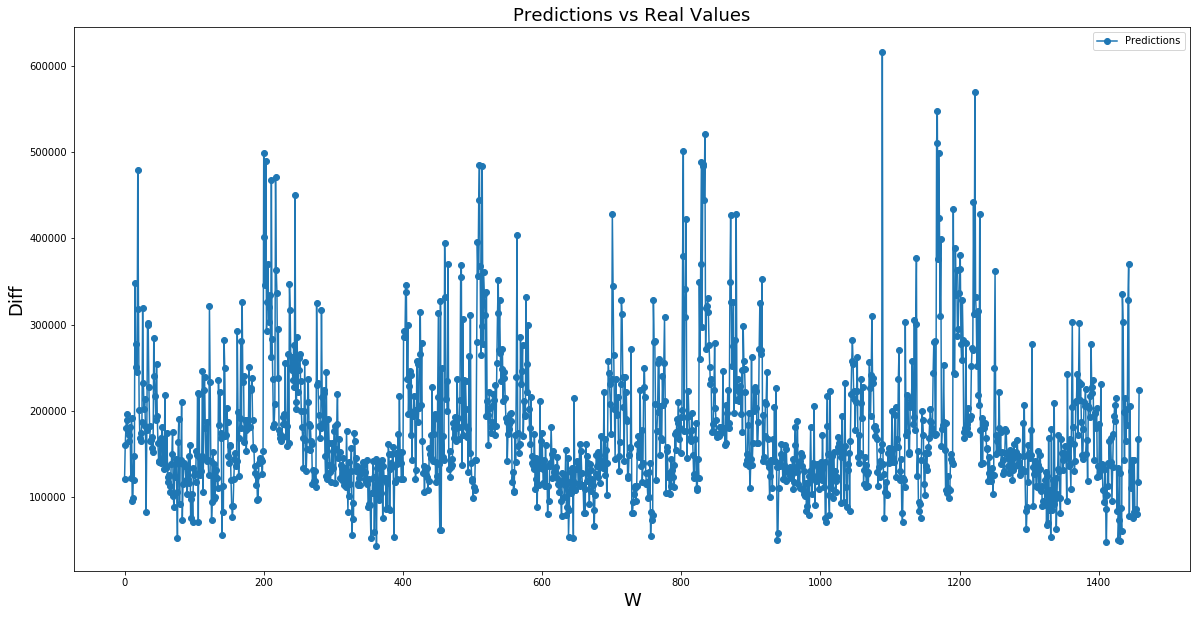

In [228]:
plt.figure(figsize=(20,10))
plt.plot([( row['SalePrice']
              ) for index, row in lgb.iterrows()], 'o-')
plt.xlabel('W', fontsize=18)
plt.ylabel('Diff', fontsize=18)
plt.title('Predictions vs Real Values', fontsize=18)
plt.legend(['Predictions'], fontsize=10, loc='upperleft')
plt.show()

In [ ]:
lgb2,rmlgb2,mlgb2=predict_data(df_model2,model_lgb)

In [ ]:
rmlgb2

In [ ]:
lgb2.head(5)

In [ ]:
lgb3,rmlgb3,mlgb3=predict_data(df_model3,model_lgb)

In [ ]:
rmlgb3

In [ ]:
lgb3.head(5)

### XGBRegressor

In [339]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [340]:
xgb,rmxgb,mxgb=predict_data(df_model,model_xgb)
xgb.head(5)

,SalePrice
1461,122799.765625
1462,154626.187500
1463,178863.718750
1464,198654.375000
1465,185202.078125


In [355]:
rmxgb

0.0678362604886968

In [341]:
xgb3,rmxgb3,mxgb3=predict_data(df_model3,model_xgb)
print(rmxgb3)
xgb3.head(5)

0.06688723711515615


,SalePrice
1461,122888.210938
1462,151885.968750
1463,179197.500000
1464,198029.593750
1465,184531.609375


In [203]:
#we notice that some models and datasets give higher values, while others give lower values so we 
#get the mean of models prediction values, we tried different 
#models and we get the best score using the following models

In [213]:
all_predict=pd.concat([gbr,gbr4,gbr3,gbr5,gbr6,p,pE,pR,pBR2,L,lgb],axis=1)

In [214]:
all_predict.head(7)

,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice,SalePrice
1461,125954.635801,130521.044206,129899.983121,125792.186140,129648.404508,116360.693449,116013.511720,118406.074542,115246.644562,117941.500180,121445.909451
1462,156120.001299,159456.290714,158252.312842,157164.260202,155632.367401,147798.410493,154418.913579,157997.582370,152988.044277,157019.466151,161045.290496
1463,198525.683050,186962.200137,187686.839357,186946.920001,187748.983155,179439.761744,184817.975667,181279.259159,178368.819953,186974.758019,180413.061054
1464,204417.044059,201852.932602,200075.244411,194868.363349,199798.385422,194784.505290,195218.494416,197034.439249,191848.596733,197717.326184,196028.792326
1465,196111.177127,182486.794318,187176.597284,185698.012299,188996.221233,193495.611800,196975.718229,194416.217523,199500.754213,196620.745703,189849.460754
1466,183862.650012,171827.236224,174037.570471,175922.833653,174886.481373,172475.554030,170907.148375,171645.376200,169381.597598,171280.406008,177321.083531
1467,183589.153754,173779.941777,170417.213369,176571.846913,172994.427305,179633.950297,174096.549085,174047.505305,173469.156967,175507.811463,172676.402409


In [215]:
f=[]
for index,row in all_predict.iterrows():
    f.append(np.mean(row))
f=pd.DataFrame(f)
f.columns=['SalePrice']
f.index=range(1461,2920)
#we notice that our models give a very high value to this point so we
#fix this problem by decresing its value
f.loc[2550]=400000

In [216]:
q1 = f['SalePrice'].quantile(0.01)
q2 = f['SalePrice'].quantile(0.99)
#Manually decresing and increasing top and bottom percentiles
f['SalePrice'] = f['SalePrice'].apply(lambda x: x if x > q1 else x*0.9)
f['SalePrice'] = f['SalePrice'].apply(lambda x: x if x < q2 else x*1.066)
f['SalePrice'] = f['SalePrice'].apply(lambda x: x if x < 550000 else x*0.98)

In [227]:
f[0:12]

,SalePrice
1461,122475.507971
1462,156172.085439
1463,185378.569209
1464,197604.011276
1465,191938.846408
1466,173958.903407
1467,175162.178059
1468,165276.179234
1469,193193.932963
1470,119443.245056


------------------------------------------------------------------------------------------